In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import torch

from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical 

from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import json

from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import Callback
import numpy as np
import pickle

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = json.load(open('../Dataset/BIO_Tagged/ATE_train.json'))
val_data = json.load(open('../Dataset/BIO_Tagged/ATE_val.json'))
test_data = json.load(open('../Dataset/BIO_Tagged/ATE_test.json'))

In [3]:
word2vec = pickle.load(open('Word Embeddings/word2vec.pkl', 'rb'))
glove = pickle.load(open('Word Embeddings/glove.pkl', 'rb'))
# Add another embedding here

In [84]:
# word_to_idx = {}

# for case in train_data:
#     for text in train_data[case]['text'].split(' '):
#         if text not in word_to_idx:
#             word_to_idx[text] = len(word_to_idx)

# for case in test_data:
#     for text in test_data[case]['text'].split(' '):
#         if text not in word_to_idx:
#             word_to_idx[text] = len(word_to_idx)

# for case in val_data:
#     for text in val_data[case]['text'].split(' '):
#         if text not in word_to_idx:
#             word_to_idx[text] = len(word_to_idx)

In [85]:
# tag_to_ix = {}

# for case in train_data:
#     for tag in train_data[case]['labels']:
#         if tag not in tag_to_ix:
#             tag_to_ix[tag] = len(tag_to_ix)

# for case in test_data:
#     for tag in test_data[case]['labels']:
#         if tag not in tag_to_ix:
#             tag_to_ix[tag] = len(tag_to_ix)

# for case in val_data:
#     for tag in val_data[case]['labels']:
#         if tag not in tag_to_ix:
#             tag_to_ix[tag] = len(tag_to_ix)

# tag_to_ix['START_TAG'] = len(tag_to_ix)
# tag_to_ix['END_TAG'] = len(tag_to_ix)

In [87]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")

In [88]:
# embedding_mat = np.zeros((len(word_to_idx), 768))

# for word, idx in tqdm(word_to_idx.items()):
#     try:
#         tokens = tokenizer.batch_encode_plus([word], return_tensors='pt', add_special_tokens=False)
#     except:
#         tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#         continue
#     embeddings = None
#     with torch.no_grad():
#         try:
#             outputs = model(**tokens)
#             embeddings = outputs.last_hidden_state
#         except:
#             tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#             outputs = model(**tokens)
#             embeddings = outputs.last_hidden_state
#     embeddings = embeddings.squeeze(0)
#     word_embeddings = embeddings.mean(dim = 0)
#     embedding_mat[idx] = word_embeddings.squeeze(0).numpy()

 30%|███       | 1049/3495 [00:44<01:38, 24.87it/s]

In [ ]:
# pickle.dump(embedding_mat, open('Word Embeddings/bert.pkl', 'wb'))

In [4]:
def create_embedding_matrix(model, word_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in model.wv:
            embedding_matrix[i] = model.wv[word]
        # Else, you can choose to initialize randomly or use a special token here
    return embedding_matrix

In [33]:
def prepareData(train_data, val_data, test_data, embedding_type):
    # Combine all datasets for consistent tokenization and vocabulary creation
    all_data = {**train_data, **val_data, **test_data}
        
    # Extract texts and labels from the combined data
    texts = [item["text"] for item in all_data.values()]
    labels = [item["labels"] for item in all_data.values()]

    word_tokenizer = Tokenizer()                      
    word_tokenizer.fit_on_texts(texts)                    
    
    train_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in train_data.values()])
    val_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in val_data.values()])
    test_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in test_data.values()])

    max_sequence_length = max(len(seq) for seq in train_sequences + val_sequences + test_sequences)
    vocab_size = len(word_tokenizer.word_index) + 1  # Adding 1 for the zero-padding

    X_train = pad_sequences(train_sequences, maxlen=max_sequence_length)
    X_val = pad_sequences(val_sequences, maxlen=max_sequence_length)
    X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

    tag_tokenizer = Tokenizer()
    tag_tokenizer.fit_on_texts(labels)

    train_labels = word_tokenizer.texts_to_sequences([item["labels"] for item in train_data.values()])
    val_labels = word_tokenizer.texts_to_sequences([item["labels"] for item in val_data.values()])
    test_labels = word_tokenizer.texts_to_sequences([item["labels"] for item in test_data.values()])

    max_label_length = max(len(label) for label in train_labels + val_labels + test_labels)
    num_classes = len(tag_tokenizer.word_index) + 1  # Adding 1 for the zero-padding

    Y_train = pad_sequences(train_labels, maxlen=max_label_length)
    Y_val = pad_sequences(val_labels, maxlen=max_label_length)
    Y_test = pad_sequences(test_labels, maxlen=max_label_length)

    embedding_dim = embedding_type.vector_size
    embedding_matrix = np.zeros((len(word_tokenizer.word_index) + 1, embedding_dim))
    word2id = word_tokenizer.word_index
    for word, index in word2id.items():
        try:
            embedding_matrix[index, :] = embedding_type[word]
        except KeyError:
            pass   

    Y_train = to_categorical(Y_train, num_classes=4)
    Y_val = to_categorical(Y_val, num_classes=4)
    Y_test = to_categorical(Y_test, num_classes=4)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, embedding_matrix, word_tokenizer, tag_tokenizer

In [34]:
data = {}
data['word2vec'] = {}
data['glove'] = {}
data['bert'] = {}

data['word2vec']['X_train'], data['word2vec']['X_val'], data['word2vec']['X_test'], data['word2vec']['Y_train'], data['word2vec']['Y_val'], data['word2vec']['Y_test'], data['word2vec']['vocab_size'], data['word2vec']['embedding_dim'], data['word2vec']['max_sequence_length'], data['word2vec']['num_classes'], data['word2vec']['embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, val_data, test_data, word2vec)

# data['glove']['X_train'], data['glove']['Y_train'], data['glove']['embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, val_data, test_data, glove)



IndexError: index 1179 is out of bounds for axis 1 with size 4

In [30]:
class MacroF1ScoreCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = np.argmax(self.model.predict(self.train_data[0]), axis=-1)
        train_true = np.argmax(self.train_data[1], axis=-1)
        train_f1 = f1_score(train_true.flatten(), train_pred.flatten(), average='macro')

        val_pred = np.argmax(self.model.predict(self.val_data[0]), axis=-1)
        val_true = np.argmax(self.val_data[1], axis=-1)
        val_f1 = f1_score(val_true.flatten(), val_pred.flatten(), average='macro')

        self.train_f1s.append(train_f1)
        self.val_f1s.append(val_f1)
        print(f'Epoch {epoch + 1} - Train Macro-F1: {train_f1:.4f} - Val Macro-F1: {val_f1:.4f}')


## VANILLA RNN

In [31]:
def trainRNN(embedding):
    X_train, Y_train, X_val, Y_val, embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['embedding_matrix']
    
    NUM_CLASSES = data[embedding]['num_classes']
    VOCABULARY_SIZE = data[embedding]['vocab_size']
    EMBEDDING_SIZE = data[embedding]['embedding_dim']
    MAX_SEQUENCE_LENGTH = data[embedding]['max_sequence_length']

    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=True))

    rnn_model.add(SimpleRNN(64, return_sequences=True))

    rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    rnn_model.save(f'Models/t2_rnn_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


In [32]:
trainRNN('word2vec')

Epoch 1/10


ValueError: in user code:

    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 81, 1180) and (None, 74, 4) are incompatible


Epoch 1/10
7/7 [==============================] - 0s 8ms/step
Epoch 1 - Train Macro-F1: 0.4924 - Val Macro-F1: 0.4765
8/8 [==============================] - 3s 184ms/step - loss: 0.9863 - acc: 0.8796 - val_loss: 0.5458 - val_acc: 0.9100
Epoch 2/10
7/7 [==============================] - 0s 7ms/step
Epoch 2 - Train Macro-F1: 0.5336 - Val Macro-F1: 0.4862
8/8 [==============================] - 1s 112ms/step - loss: 0.4315 - acc: 0.9077 - val_loss: 0.3691 - val_acc: 0.8977
Epoch 3/10
7/7 [==============================] - 0s 7ms/step
Epoch 3 - Train Macro-F1: 0.5929 - Val Macro-F1: 0.5107
8/8 [==============================] - 1s 111ms/step - loss: 0.3002 - acc: 0.9124 - val_loss: 0.3063 - val_acc: 0.9028
Epoch 4/10
7/7 [==============================] - 0s 7ms/step
Epoch 4 - Train Macro-F1: 0.6396 - Val Macro-F1: 0.5153
8/8 [==============================] - 1s 111ms/step - loss: 0.2346 - acc: 0.9274 - val_loss: 0.2817 - val_acc: 0.9134
Epoch 5/10
7/7 [==============================] - 0s

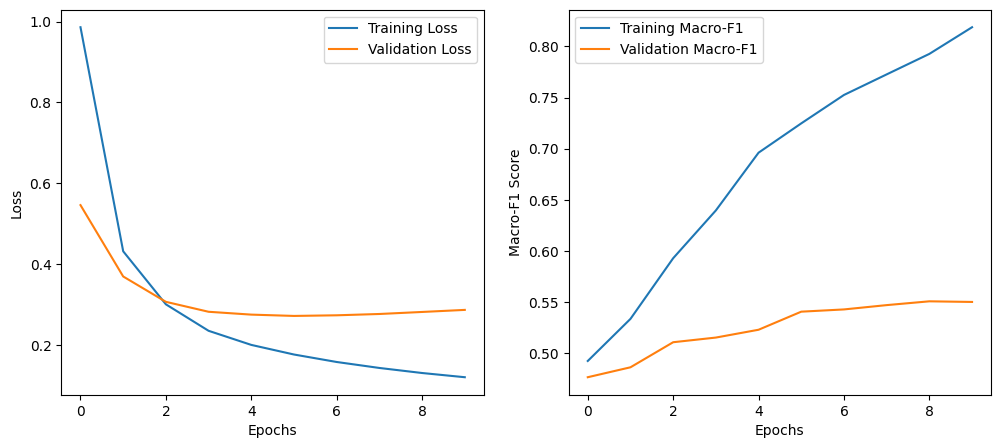

In [20]:
trainRNN('glove')

In [23]:
trainRNN('bert')

ValueError: Layer embedding_4 weight shape (2405, 300) is not compatible with provided weight shape ().

## LSTM

In [14]:
def trainLSTM(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    lstm_model.add(LSTM(64, return_sequences=True))

    lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    lstm_model.save(f'Models/t2_lstm_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 16ms/step
Epoch 1 - Train Macro-F1: 0.4657 - Val Macro-F1: 0.4642
8/8 [==============================] - 6s 426ms/step - loss: 1.2509 - acc: 0.8868 - val_loss: 1.0307 - val_acc: 0.9124
Epoch 2/10
7/7 [==============================] - 0s 12ms/step
Epoch 2 - Train Macro-F1: 0.4381 - Val Macro-F1: 0.4364
8/8 [==============================] - 2s 218ms/step - loss: 0.8607 - acc: 0.9005 - val_loss: 0.6118 - val_acc: 0.8658
Epoch 3/10
7/7 [==============================] - 0s 15ms/step
Epoch 3 - Train Macro-F1: 0.4565 - Val Macro-F1: 0.4559
8/8 [==============================] - 1s 196ms/step - loss: 0.5321 - acc: 0.8671 - val_loss: 0.4245 - val_acc: 0.8981
Epoch 4/10
7/7 [==============================] - 0s 13ms/step
Epoch 4 - Train Macro-F1: 0.4609 - Val Macro-F1: 0.4603
8/8 [==============================] - 1s 192ms/step - loss: 0.3769 - acc: 0.9041 - val_loss: 0.3386 - val_acc: 0.9058
Epoch 5/10
7/7 [==============================] 

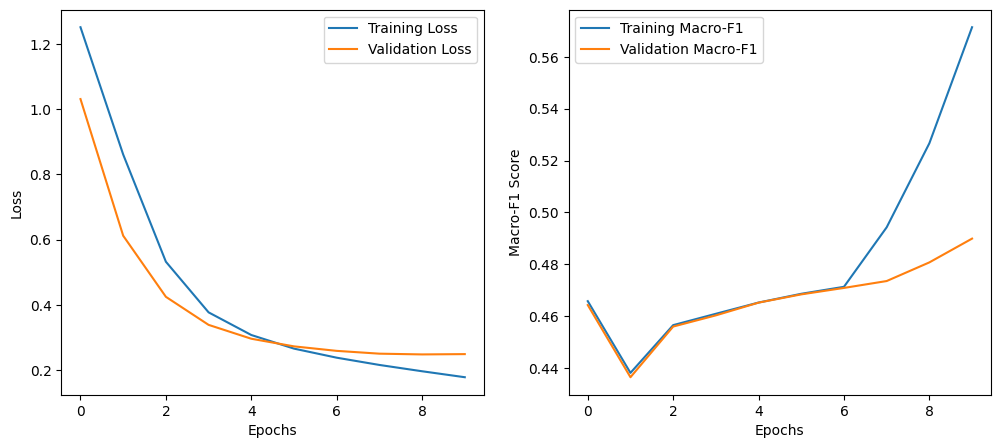

In [15]:
trainLSTM('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 12ms/step
Epoch 1 - Train Macro-F1: 0.4731 - Val Macro-F1: 0.4708
8/8 [==============================] - 5s 321ms/step - loss: 1.3138 - acc: 0.7761 - val_loss: 1.0274 - val_acc: 0.9232
Epoch 2/10
7/7 [==============================] - 0s 26ms/step
Epoch 2 - Train Macro-F1: 0.4663 - Val Macro-F1: 0.4657
8/8 [==============================] - 2s 335ms/step - loss: 0.9029 - acc: 0.9215 - val_loss: 0.6896 - val_acc: 0.9146
Epoch 3/10
7/7 [==============================] - 0s 25ms/step
Epoch 3 - Train Macro-F1: 0.4472 - Val Macro-F1: 0.4467
8/8 [==============================] - 2s 330ms/step - loss: 0.5442 - acc: 0.8981 - val_loss: 0.4522 - val_acc: 0.8822
Epoch 4/10
7/7 [==============================] - 0s 29ms/step
Epoch 4 - Train Macro-F1: 0.4602 - Val Macro-F1: 0.4595
8/8 [==============================] - 2s 334ms/step - loss: 0.3932 - acc: 0.8896 - val_loss: 0.3429 - val_acc: 0.9041
Epoch 5/10
7/7 [==============================] 

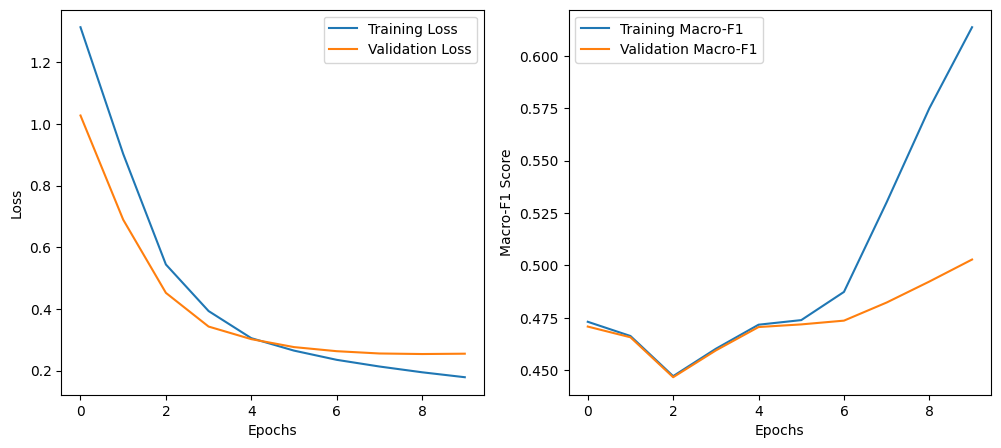

In [16]:
trainLSTM('glove')

In [ ]:
trainLSTM('bert')

## GRU

In [17]:
def trainGRU(embedding):
    X_train, Y_train, X_val, Y_val, train_embedding_matrix, val_embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['train_embedding_matrix'], data[embedding]['val_embedding_matrix']
    
    NUM_CLASSES = Y_train.shape[2]
    VOCABULARY_SIZE = 2405
    EMBEDDING_SIZE = 300
    MAX_SEQUENCE_LENGTH = 50

    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[train_embedding_matrix],
                            trainable=True))

    gru_model.add(GRU(64, return_sequences=True))

    gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    gru_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    gru_model.save(f'Models/t2_gru_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/10
7/7 [==============================] - 0s 13ms/step
Epoch 1 - Train Macro-F1: 0.4741 - Val Macro-F1: 0.4716
8/8 [==============================] - 5s 374ms/step - loss: 1.2271 - acc: 0.9035 - val_loss: 1.0027 - val_acc: 0.9245
Epoch 2/10
7/7 [==============================] - 0s 14ms/step
Epoch 2 - Train Macro-F1: 0.4677 - Val Macro-F1: 0.4672
8/8 [==============================] - 1s 170ms/step - loss: 0.8320 - acc: 0.9228 - val_loss: 0.5701 - val_acc: 0.9173
Epoch 3/10
7/7 [==============================] - 0s 18ms/step
Epoch 3 - Train Macro-F1: 0.4587 - Val Macro-F1: 0.4575
8/8 [==============================] - 2s 202ms/step - loss: 0.4173 - acc: 0.9088 - val_loss: 0.3420 - val_acc: 0.9009
Epoch 4/10
7/7 [==============================] - 0s 17ms/step
Epoch 4 - Train Macro-F1: 0.4712 - Val Macro-F1: 0.4645
8/8 [==============================] - 1s 198ms/step - loss: 0.2888 - acc: 0.9019 - val_loss: 0.2865 - val_acc: 0.9123
Epoch 5/10
7/7 [==============================] 

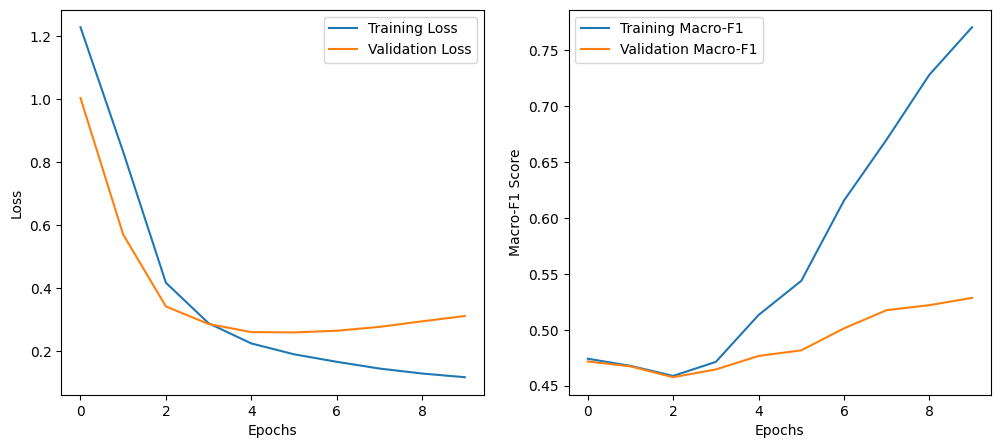

In [18]:
trainGRU('word2vec')

Epoch 1/10
7/7 [==============================] - 0s 11ms/step
Epoch 1 - Train Macro-F1: 0.4755 - Val Macro-F1: 0.4722
8/8 [==============================] - 5s 278ms/step - loss: 1.2423 - acc: 0.8219 - val_loss: 0.9710 - val_acc: 0.9253
Epoch 2/10
7/7 [==============================] - 0s 12ms/step
Epoch 2 - Train Macro-F1: 0.4793 - Val Macro-F1: 0.4737
8/8 [==============================] - 1s 150ms/step - loss: 0.8341 - acc: 0.9234 - val_loss: 0.6449 - val_acc: 0.9252
Epoch 3/10
7/7 [==============================] - 0s 22ms/step
Epoch 3 - Train Macro-F1: 0.4968 - Val Macro-F1: 0.4723
8/8 [==============================] - 1s 159ms/step - loss: 0.4591 - acc: 0.9236 - val_loss: 0.3151 - val_acc: 0.9146
Epoch 4/10
7/7 [==============================] - 0s 18ms/step
Epoch 4 - Train Macro-F1: 0.5700 - Val Macro-F1: 0.4943
8/8 [==============================] - 1s 158ms/step - loss: 0.2472 - acc: 0.9178 - val_loss: 0.2785 - val_acc: 0.9020
Epoch 5/10
7/7 [==============================] 

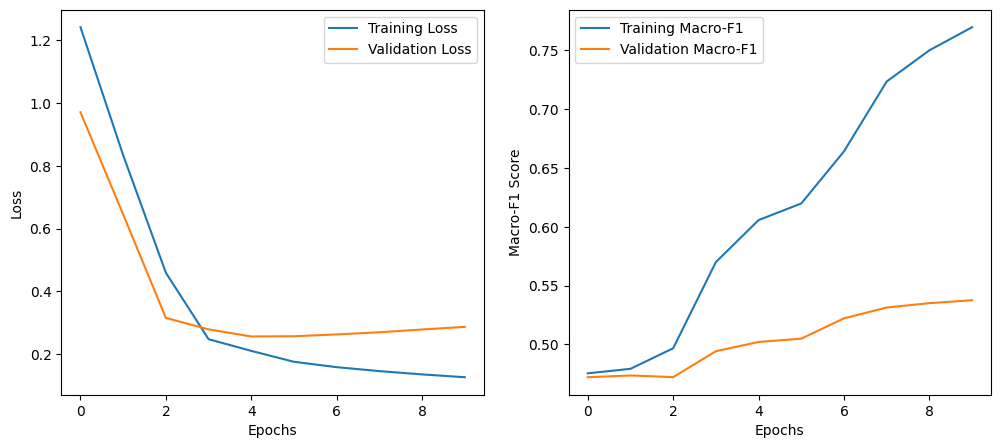

In [19]:
trainGRU('glove')

In [ ]:
trainGRU('bert')

## EVALUATION

In [20]:
def get_aspect_terms(test_pred, X_test):
    aspect_terms = []
    for i in range(len(test_pred)):
        aspect_term = []
        for j in range(len(test_pred[i])):
            if test_pred[i][j] == 1:
                aspect_term.append(word_tokenizer.index_word[X_test[i][j]])
        aspect_terms.append(aspect_term)
    return aspect_terms

In [21]:
def evaluate_model(model, X_test, Y_test):
    Y_pred = np.argmax(model.predict(X_test), axis=-1)
    Y_true = np.argmax(Y_test, axis=-1)

    aspect_terms = get_aspect_terms(Y_pred, X_test)

    print(f'Macro F1 Score: {f1_score(Y_true.flatten(), Y_pred.flatten(), average="macro"):.4f}')
    print(f'Accuracy: {accuracy_score(Y_true.flatten(), Y_pred.flatten())*100:.2f}%')

    return aspect_terms

In [24]:
rnn_word2vec = load_model('Models/t2_rnn_word2vec.h5')
rnn_glove = load_model('Models/t2_rnn_glove.h5')
rnn_bert = load_model('Models/t2_rnn_bert.h5')

lstm_word2vec = load_model('Models/t2_lstm_word2vec.h5')
lstm_glove = load_model('Models/t2_lstm_glove.h5')
lstm_bert = load_model('Models/t2_lstm_bert.h5')

gru_word2vec = load_model('Models/t2_gru_word2vec.h5')
gru_glove = load_model('Models/t2_gru_glove.h5')
gru_bert = load_model('Models/t2_gru_bert.h5')


print("RNN Word2Vec")
rnn_word2vec_aspect_terms = evaluate_model(rnn_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("RNN Glove")
rnn_glove_aspect_terms = evaluate_model(rnn_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("RNN bert")
rnn_bert_aspect_terms = evaluate_model(rnn_bert, data['bert']['X_test'], data['bert']['Y_test'])

print()
print("LSTM Word2Vec")
lstm_word2vec_aspect_terms = evaluate_model(lstm_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("LSTM Glove")
lstm_glove_aspect_terms = evaluate_model(lstm_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("LSTM bert")
lstm_bert_aspect_terms = evaluate_model(lstm_bert, data['bert']['X_test'], data['bert']['Y_test'])

print()
print("GRU Word2Vec")
gru_word2vec_aspect_terms = evaluate_model(gru_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("GRU Glove")
gru_glove_aspect_terms = evaluate_model(gru_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("GRU bert")
gru_bert_aspect_terms = evaluate_model(gru_bert, data['bert']['X_test'], data['bert']['Y_test'])

RNN Word2Vec
11/11 [==============================] - 0s 8ms/step
Macro F1 Score: 0.5388
Accuracy: 90.84%

RNN Glove
11/11 [==============================] - 0s 8ms/step
Macro F1 Score: 0.5311
Accuracy: 90.79%

LSTM Word2Vec
11/11 [==============================] - 1s 15ms/step
Macro F1 Score: 0.4959
Accuracy: 91.90%

LSTM Glove
11/11 [==============================] - 1s 21ms/step
Macro F1 Score: 0.5019
Accuracy: 91.61%

GRU Word2Vec
11/11 [==============================] - 1s 17ms/step
Macro F1 Score: 0.5225
Accuracy: 90.68%

GRU Glove
11/11 [==============================] - 1s 17ms/step
Macro F1 Score: 0.5280
Accuracy: 90.80%
